In [50]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# from torcheval.metrics.functional import binary_accuracy


# Preprocessing/ setting up data sets

## import data from tsv and get the sequence length to use for padding

In [51]:
# import data.tsv file and create a dataframe

df = pd.read_csv('data.tsv', sep='\t')

# open file data_info.txt and read the first line

sequence_length = None
with open('data_info.txt', 'r') as f:
    line = f.readline()
    split_line_on_collen = line.split(':')
    sequence_length = int(split_line_on_collen[1])
    

## Split into train and test 

In [52]:

train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

## balance the positive and negative 

In [53]:
train_df_sit_ups = train_df[train_df['Y'] == 1]
train_df_non_sit_ups = train_df[train_df['Y'] == 0]


train_df_non_sit_ups_balanced = train_df_non_sit_ups.sample(n=len(train_df_sit_ups), random_state=0)


train_df = pd.concat([train_df_sit_ups, train_df_non_sit_ups])

test_df_sit_ups = test_df[test_df['Y'] == 1]
test_df_non_sit_ups = test_df[test_df['Y'] == 0]

test_df_non_sit_ups = test_df_non_sit_ups.sample(n=len(test_df_sit_ups), random_state=0)

test_df_balanced = pd.concat([test_df_sit_ups, test_df_non_sit_ups])

## separate x and y from test and training

In [54]:
train_x = train_df.drop(['Y'], axis=1).iloc[1:]
train_y = train_df['Y'].iloc[1:]

test_x = test_df.drop(['Y'], axis=1)


test_y = test_df['Y']

## Convert the cells in each collumn of the dataframe from string to a numpy array and convert the whole dataframe to numpy array

In [55]:
def convert_rows_to_nupy_array(df):
    numpy_array = []
    for index, row in df.iterrows():
        row_array = []
        for col in row.iteritems():
            col_float = []
            for item in col[1].split(','):
                col_float.append(float(item.replace('[', '').replace(']', '')))
            row_array.append(col_float)
        numpy_array.append(row_array)
    return np.array(numpy_array)

train_x_numpy = convert_rows_to_nupy_array(train_x)
test_x_numpy = convert_rows_to_nupy_array(test_x)

print(train_x_numpy.shape)
print(test_x_numpy[1][5])
            

(2057, 749, 3)
[ 0.51171875 -0.10406494 -0.10406494]


##### Remove Padding from numpy and create separate dataset

In [56]:
train_y_no_pad = train_y
test_y_no_pad = test_y

# remove the numpy array where you hava a [0,0,0] array

test_np_array = np.array([[1,2,1], [0,0,0], [1,2,1]])

# remove the [0,0,0] array from the numpy array test_np_array

test_np_array = test_np_array[test_np_array[:,0] != 0]



train_x_numpy_no_pad = []
# row_index = 0
for row in range(len(train_x_numpy)):
    temp = train_x_numpy[row][train_x_numpy[row][:,0] != 0]
    temp_list = []
    for col in temp:
        item_list = []
        for item in col:
            item_list.append(item)
        temp_list.append(item_list)
    train_x_numpy_no_pad.append(temp_list)
train_x_numpy_no_pad = np.array(train_x_numpy_no_pad)
print(train_x_numpy_no_pad.shape)


(2057,)


/tmp/ipykernel_766139/3299080516.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_x_numpy_no_pad = np.array(train_x_numpy_no_pad)


## Train

## Dummy Classifier

In [57]:
# Dummy Classifer

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent")
print(train_x_numpy.shape, train_y.shape)
dummy_clf.fit(train_x_numpy, train_y)
y_pred = dummy_clf.predict(test_x_numpy)
print(accuracy_score(test_y, y_pred))

(2057, 749, 3) (2057,)
0.7704280155642024


## Recurrent Neural Classifier

### Dataset loader

In [58]:

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, input,target, seq_len):
        self.input = input
        self.target = target
        self.seq_len = seq_len
    def __getitem__(self, item):
        return self.input[item], self.target.iloc[item]

    def __len__(self):
        return  self.input.shape[0]

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyper parameters

In [60]:
input_size = 3                                                                           
num_classes = 1
hidden_size = 3
num_layers = 2
learning_rate = 0.001
batch_size = 1
num_epochs = 1
clip = 5

### For testing reduce to certain size

In [61]:
# reduce size of train_x_numpy_no_pad to 1000
train_x_numpy = train_x_numpy[:50]
train_y = train_y[:50]

test_x_numpy = test_x_numpy[:50]
test_y = test_y[:50]


# print how many 1 and 0 in the train_y
print(train_y.value_counts())

1    50
Name: Y, dtype: int64


## Neural Network Archetecture

In [62]:
class SitUpDetector(nn.Module):
    def __init__(self,input_size, num_classes, hidden_size, num_layers,drop_prob=0.5):
        super(SitUpDetector, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, hidden):
        batch_size = x.size(0)
        out, _ = self.lstm(x, hidden)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]
        return out,hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().float().to(device),
                      weight.new(self.num_layers, batch_size, self.hidden_size).zero_().float().to(device)) 
        return hidden
    

## Create Model, Optimizers, dataloader and other variables

In [63]:
model = SitUpDetector(input_size, num_classes, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



myDataset = MyDataset(train_x_numpy,train_y, sequence_length)
train_loader = torch.utils.data.DataLoader(dataset=myDataset, batch_size=batch_size)

losses = []
loss = None
valid_loss_min = np.Inf
total_steps = len(train_loader)


### Train Network

Epoch: 1/1... Step: 49... Loss: 0.807959... Val Loss: 0.715517
losses as np array [0.80795854]
Validation loss decreased (inf --> 0.715517).  Saving model ...
plt y shpae loss (1,)


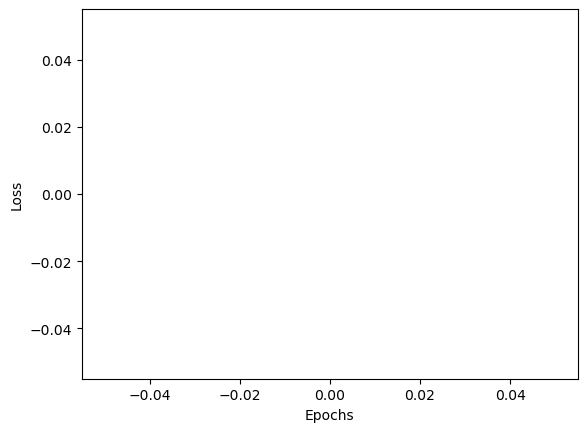

In [64]:

model.train()
for epoch in range(num_epochs):
    h = model.init_hidden(batch_size)
    for i, (features, target) in enumerate(train_loader):

        h = tuple([e.data for e in h])

        features, target = features.to(device), target.to(device)
        model.zero_grad()
        outputs, h = model(features.float(), h)
        loss = criterion(outputs, target.float())
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        loss.backward()

        optimizer.step()
        if (i+1) % 50 == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in train_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp.float(), val_h)
                val_loss = criterion(out, lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(epoch+1, num_epochs),
                  "Step: {}...".format(i),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            losses.append(loss.item())
            # print("why","{:.6f}".format(loss.item().detach().numpy()))


            print("losses as np array",np.array(losses))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

# graph the losses 

# get the lenght of the losses array

# create an array of the same length as the losses array with index values
for i in range(len(losses)):
    if type(losses[i]) == torch.Tensor:
        losses[i] = losses[i].detach().numpy()

y = np.array(losses)
print("plt y shpae loss", y.shape)
# print("y shpae")
# print(y)

x = np.arange(0,len(losses))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()
plt.savefig(f"loss-for-params-num-{num_layers}-learning_rate{learning_rate}.png")
plt.show()






# Confusion Matrix
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(test_y, all_predictions)
# print(cm)
# sns.heatmap(cm, annot=True, fmt="d")

torch.save(model.state_dict(), 'sit_up_detector.pth')


## Test Accuracy

In [65]:
# Check accuracy
test_dataset = MyDataset(train_x_numpy,train_y, sequence_length)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1)
n_correct = 0
n_samples = 0
model.eval()

all_predictions = []


test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)


model.eval()
for inputs, label in train_loader:
    h = tuple([each.data for each in h])
    inputs, label = inputs.to(device), label.to(device)
    output, h = model(inputs.float(), h)
    test_loss = criterion(output, label.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(label.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_dataloader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

Test loss: 0.716
Test accuracy: 0.000%


# Train with different network with data spread out and with simpler rnn

In [66]:
test_flatten = train_x_numpy[0].flatten()

# flatten the rows in train_x_numpy to 1D array
train_x_numpy_flatten_list = []
for i in range(len(train_x_numpy)):
    train_x_numpy_flatten_list.append(train_x_numpy[i].flatten().tolist())

train_x_flatten_numpy = np.array(train_x_numpy_flatten_list)

In [67]:
class MyFlattenDataset(torch.utils.data.Dataset):
    def __init__(self, input,target):
        self.input = input
        self.target = target
    def __getitem__(self, item):
        # print("input item", self.input[item])
        return self.input[item], self.target.iloc[item]

        # return input[item:item+self.seq_len], input[item+self.seq_len]
    def __len__(self):
        return self.input.shape[0]

In [68]:
input_size = 3
num_classes = 1
hidden_size = 256
num_layers = 2
learning_rate = 0.001

In [69]:
class SitUpDetectorSimplerFlattened(nn.Module):
    def __init__(self,input_size, num_classes, hidden_size):
        super(SitUpDetectorSimplerFlattened, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, num_classes)
    

    def forward(self, x):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden

    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

In [70]:
#  create pytorch lstm variable recurrent classifier






# train SitUpDetectorVariableInput
model = SitUpDetectorVariableSequenceLength(input_size, num_classes, hidden_size, num_layers).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

myDatasetVariableSequenceLengthDataset = MyDatasetVariableSequenceLength(train_x_numpy,train_y, sequence_length)
train_loader = torch.utils.data.DataLoader(dataset=myDatasetVariableSequenceLengthDataset, batch_size=1, shuffle=False)

losses = []
loss = None
num_epochs = 1
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (features, target) in enumerate(train_loader):

        # convert Double tensor to Float tensor
        features = features.float()

        outputs = model(features)
        
        loss = criterion(outputs, target.float())

        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_steps, loss.item()))
    losses.append(loss.item())



NameError: name 'SitUpDetectorVariableSequenceLength' is not defined

# Multivariate classifier

### Imports

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
# from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator


from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_multi_index_to_3d_numpy,
    from_nested_to_3d_numpy,
)

### Test with example

In [ ]:
X, y = load_basic_motions(return_X_y=True)
print(X.shape)
print(y.shape)
print(y[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()
np.unique(y_train)


steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("score", score)

clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

print("score ", score)

# clf = MrSEQLClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)

(80, 6)
(80,)
standing
(60, 6) (60,) (20, 6) (20,)


KeyboardInterrupt: 

## implement on my data

### convert current dataset to sktime format

In [ ]:
# import data.tsv file and create a dataframe

df = pd.read_csv('data.tsv', sep='\t')

# open file data_info.txt and read the first line

sequence_length = None
with open('data_info.txt', 'r') as f:
    line = f.readline()
    split_line_on_collen = line.split(':')
    sequence_length = int(split_line_on_collen[1])

In [ ]:

train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
train_x = train_df.drop(['Y'], axis=1).iloc[1:]
train_y = train_df['Y'].iloc[1:]
y = train_y.to_numpy()


In [ ]:
def convert_rows_to_nupy_array(df):
    numpy_array = []
    for index, row in df.iterrows():
        row_array = []
        col_x = []
        col_y = []
        col_z = []
        for col in row.iteritems():
            col_float = []
            for item in col[1].split(','):
                col_float.append(float(item.replace('[', '').replace(']', '')))
            col_x.append(col_float[0])   
            col_y.append(col_float[1])
            col_z.append(col_float[2]) 
        row_array.append(col_x)
        row_array.append(col_y)
        row_array.append(col_z)
        numpy_array.append(row_array)
    return np.array(numpy_array)

train_x_numpy = convert_rows_to_nupy_array(train_x)

print(train_x_numpy.shape)

(2057, 3, 749)


In [ ]:

multivariate_dataframe_train_x = from_3d_numpy_to_nested(train_x_numpy)
# multivariate_dataframe_test_x = from_3d_numpy_to_nested(multivariate_list_np_test)
print(multivariate_dataframe_train_x.shape)

(2057, 3)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(multivariate_dataframe_train_x, y, random_state=42)


steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
clf = Pipeline(steps)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
print("score is", score)


clf = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=100), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5,n_jobs=-1), [2]),
    ]
)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

score is 0.6699029126213593


/home/kf7mxe/anaconda3/envs/time-series-data-mining/lib/python3.8/site-packages/sktime/classification/dictionary_based/_boss.py:215: UserWarning: ``typed_dict`` was deprecated in version 0.13.3 and will be removed in 0.15.
  warnings.warn(


0.9844660194174757


Univariate classifier